In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier 
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV, StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import pipeline, make_pipeline
from sklearn.metrics import classification_report, recall_score, roc_auc_score,roc_curve, accuracy_score, precision_score,\
f1_score, confusion_matrix, plot_confusion_matrix, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.utils import resample
from sklearn.metrics import auc
from sklearn.feature_selection import SelectFromModel
import time
import warnings
from alibi.explainers import CounterFactual
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
warnings.filterwarnings("ignore")

Using TensorFlow backend.


### Importing the transformed data saved from the "Preprocessing" Notebook:

In [2]:
t0 = time.time()
df = pd.read_csv('lending-club-loan-data/df_modeling.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
t1 = time.time()
print('Cell Runtime: {}'.format(t1-t0))

Cell Runtime: 57.70438814163208


### Assinging X, and y:

In [3]:
y = df['loan_status']
X = df.drop('loan_status',axis=1)

### Creating a Train Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Sampling the train set for faster computation time

In [5]:
ytrain_Xtrain=pd.concat([y_train, X_train], axis=1)
ytrain_Xtrain_sample = ytrain_Xtrain.sample(10000, random_state=42)
y_s = ytrain_Xtrain_sample['loan_status']
X_s = ytrain_Xtrain_sample.drop('loan_status',axis=1)

# Modeling:

# Random Forest:

### The following cell of code is a fuction that takes a model, and returns 4 metrics for the training and validation: (Recall, Precision, F1, Accuracy) and 2 graphs for the training and validation: (Confusion Matrix, ROC Curve) 

In [93]:
def imbalanced_modeling(model):

    sampler = RandomUnderSampler(random_state=42)
    cv=StratifiedKFold(n_splits=25)
    train_scores_recall = []
    train_scores_precision = []
    train_scores_f1 = []
    train_scores_accuracy = []
    
    cv_scores_recall = []
    cv_scores_precision = []
    cv_scores_f1 = []
    cv_scores_accuracy = []

    for train_fold_index, val_fold_index in cv.split(X_s, y_s):
        # Get the training data
        X_train_fold, y_train_fold = X_s.iloc[train_fold_index], y_s.iloc[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_s.iloc[val_fold_index], y_s.iloc[val_fold_index]

    # Balance only the data in the training section
    X_train_fold_resamp, y_train_fold_resamp = sampler.fit_resample(X_train_fold,y_train_fold)
    # Fit the model on the balanced training data
    model_obj = model.fit(X_train_fold_resamp, y_train_fold_resamp)

    # Score the model on the (balanced) training data
    train_score_recall = recall_score(y_train_fold_resamp, model_obj.predict(X_train_fold_resamp))
    train_scores_recall.append(train_score_recall)

    train_score_precision = precision_score(y_train_fold_resamp, model_obj.predict(X_train_fold_resamp))
    train_scores_precision.append(train_score_precision)

    train_score_f1 = f1_score(y_train_fold_resamp, model_obj.predict(X_train_fold_resamp))
    train_scores_f1.append(train_score_f1)

    train_score_accuracy = accuracy_score(y_train_fold_resamp, model_obj.predict(X_train_fold_resamp))
    train_scores_accuracy.append(train_score_accuracy)

    # Score the model on the (non-balanced) validation data
    score_recall = recall_score(y_val_fold, model_obj.predict(X_val_fold))
    cv_scores_recall.append(score_recall)

    score_precision = precision_score(y_val_fold, model_obj.predict(X_val_fold))
    cv_scores_precision.append(score_precision)

    score_f1 = f1_score(y_val_fold, model_obj.predict(X_val_fold))
    cv_scores_f1.append(score_f1)

    score_accuracy = accuracy_score(y_val_fold, model_obj.predict(X_val_fold))
    cv_scores_accuracy.append(score_accuracy)

    print('Model Train Recall: {}'.format(np.array(train_scores_recall).mean()))
    print('Model Train Precision: {}'.format(np.array(train_scores_precision).mean()))
    print('Model Train F1: {}'.format(np.array(train_scores_f1).mean()))
    print('Model Train Accuracy: {}'.format(np.array(train_scores_accuracy).mean()))
    
    fig, ax = plt.subplots(figsize=(9,9))
    disp1=plot_confusion_matrix(model_obj, X_train_fold_resamp, y_train_fold_resamp, cmap=plt.cm.Blues, values_format = 'd', ax=ax)         
    disp1.ax_.set_title('Training Confusion Matrix')
    plt.grid(False)
    plt.show()

    y_score = model_obj.predict_proba(X_train_fold_resamp)[:,1]
    fpr, tpr, threshold = roc_curve(y_train_fold_resamp, y_score)
    roc_auc = auc(fpr, tpr)
    
    fig, ax = plt.subplots(figsize=(9,7))
    plt.title('Training ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    print('-----------------------------------')
    print('CrossValidation Recall: {}'.format(np.array(cv_scores_recall).mean()))
    print('CrossValidation Precision: {}'.format(np.array(cv_scores_precision).mean()))
    print('CrossValidation F1: {}'.format(np.array(cv_scores_f1).mean()))
    print('CrossValidation Accuracy: {}'.format(np.array(cv_scores_accuracy).mean()))
    
    fig, ax = plt.subplots(figsize=(9,9))
    disp1=plot_confusion_matrix(model_obj, X_val_fold, y_val_fold, cmap=plt.cm.Blues, values_format = 'd', ax=ax)         
    disp1.ax_.set_title('CrossValidation Confusion Matrix')
    plt.grid(False)
    plt.show()

    y_score = model_obj.predict_proba(X_val_fold)[:,1]
    fpr, tpr, threshold = roc_curve(y_val_fold, y_score)
    roc_auc = auc(fpr, tpr)
    
    fig, ax = plt.subplots(figsize=(9,7))
    plt.title('CrossValidation ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

CrossValidation Recall: 0.6818181818181818
CrossValidation Precision: 0.20134228187919462
CrossValidation F1: 0.310880829015544
CrossValidation Accuracy: 0.6675


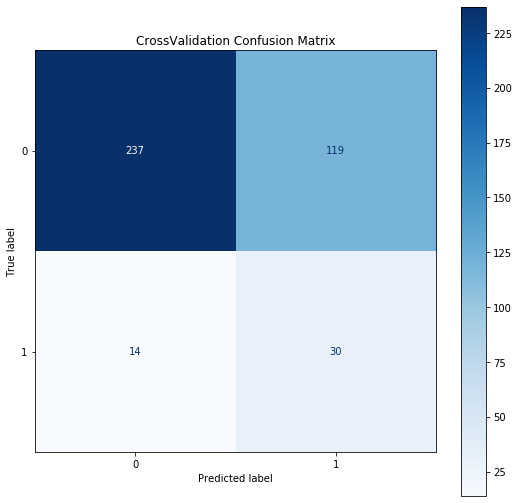

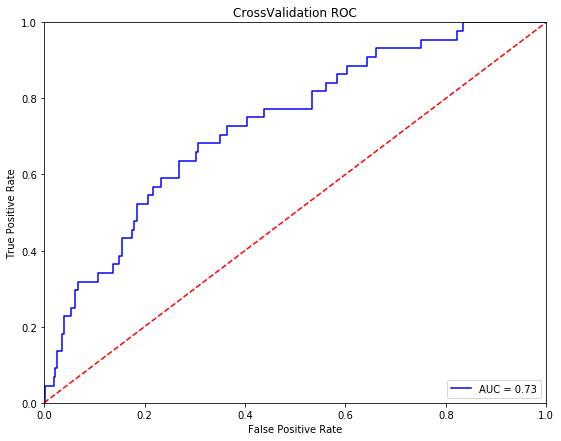

In [94]:
model=RandomForestClassifier(max_depth=6, max_features='log2')
imbalanced_modeling(model)

# Gradient Boosting

CrossValidation Recall: 0.7045454545454546
CrossValidation Precision: 0.1834319526627219
CrossValidation F1: 0.29107981220657275
CrossValidation Accuracy: 0.6225


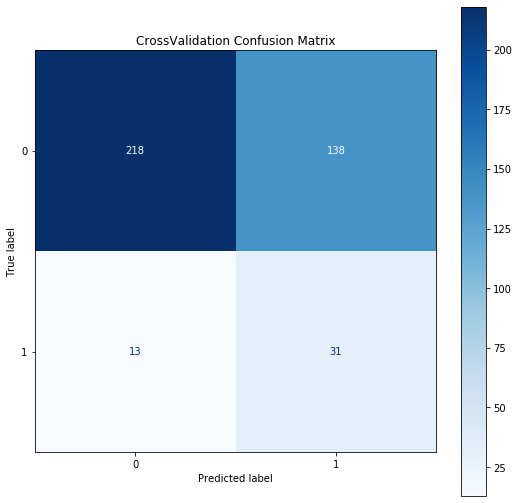

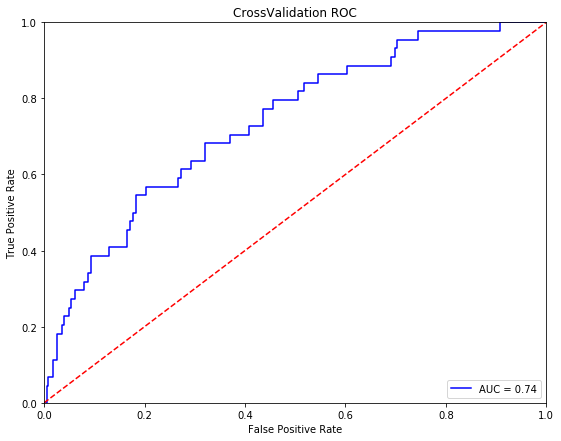

In [100]:
model=GradientBoostingClassifier(max_depth=4)
imbalanced_modeling(model)

# AdaBoost

Model Train Recall: 0.9584541062801932
Model Train Precision: 0.9411764705882353
Model Train F1: 0.9497367161321206
Model Train Accuracy: 0.9492753623188406


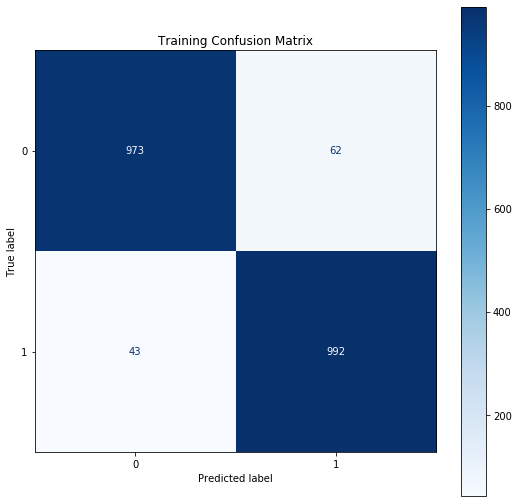

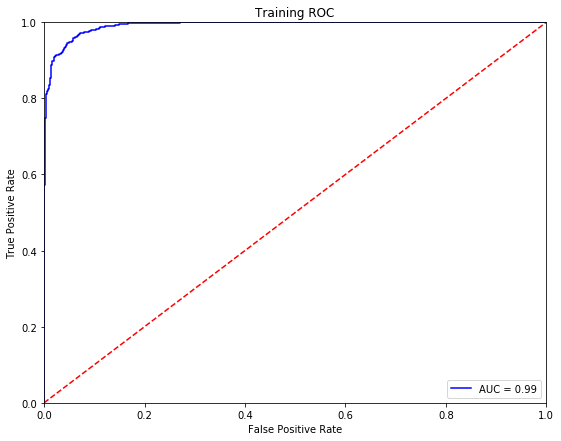

-----------------------------------
Model CrossVal Recall: 0.6136363636363636
Model CrossVal Precision: 0.16875
Model CrossVal F1: 0.2647058823529412
Model CrossVal Accuracy: 0.625


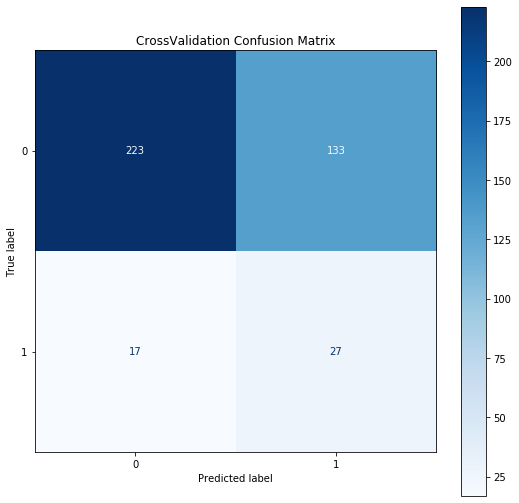

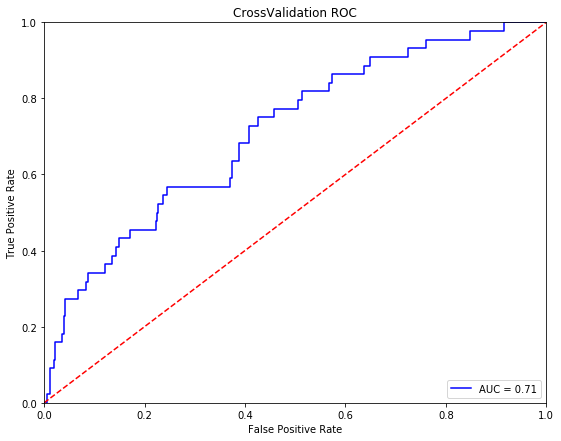

Cell Runtime: 26.2738618850708


In [91]:
t0 = time.time()
model=AdaBoostClassifier(RandomForestClassifier(max_depth=3))
imbalanced_modeling(model)
t1 = time.time()
print('Cell Runtime: {}'.format(t1-t0))

# Bagging Classifier

Model Train Recall: 0.9429951690821256
Model Train Precision: 0.9190207156308852
Model Train F1: 0.9308536003814973
Model Train Accuracy: 0.9299516908212561


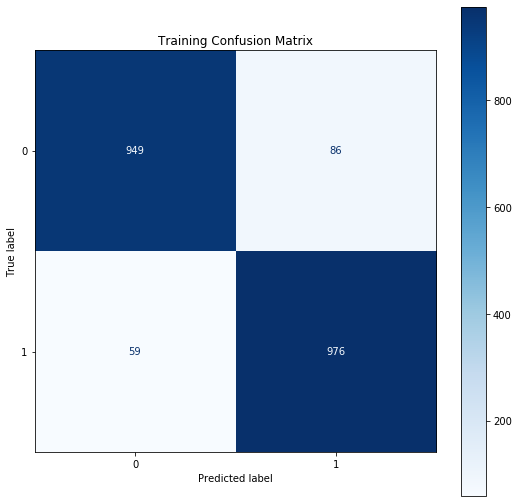

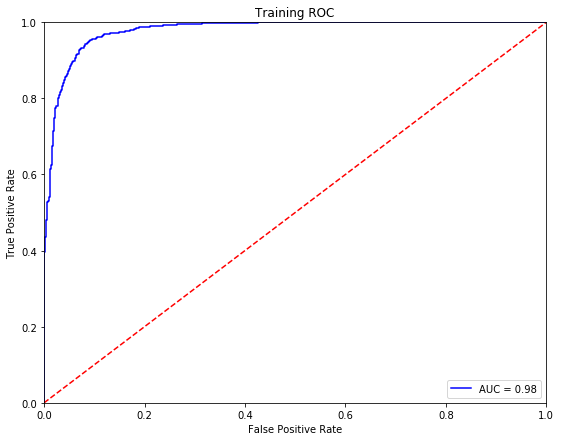

-----------------------------------
Model CrossVal Recall: 0.6590909090909091
Model CrossVal Precision: 0.19727891156462585
Model CrossVal F1: 0.3036649214659686
Model CrossVal Accuracy: 0.6675


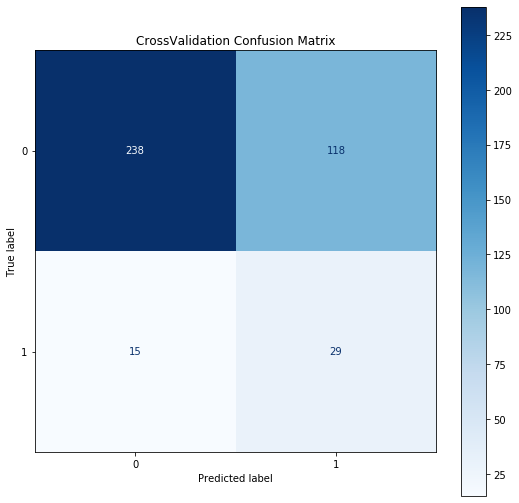

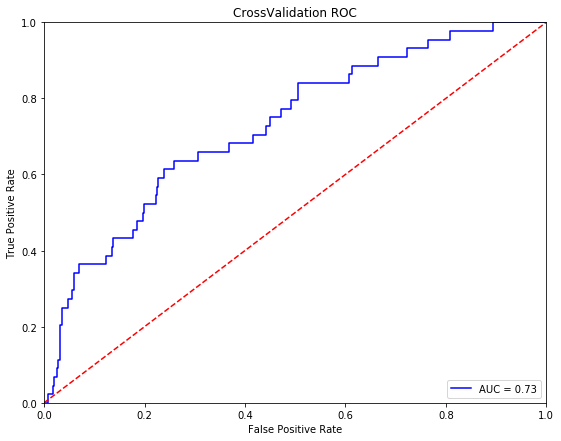

Cell Runetime: 9.269109964370728


In [92]:
t0 = time.time()
model=BaggingClassifier(RandomForestClassifier(max_depth=10))
imbalanced_modeling(model)
t1 = time.time()
print('Cell Runetime: {}'.format(t1-t0))

# Extracting Explainability

#### Using the SHAP library, shapely values can be used to extract insightful explainability from the models:

In [124]:
import shap

#### The following cell of code is a modification of the "imbalanced modeling" function defined earlier. In this case, the code for the training and crossvalidation window outputs are removed, and SHAP code is put in its place. 

 98%|===================| 2021/2070 [00:21<00:00]        

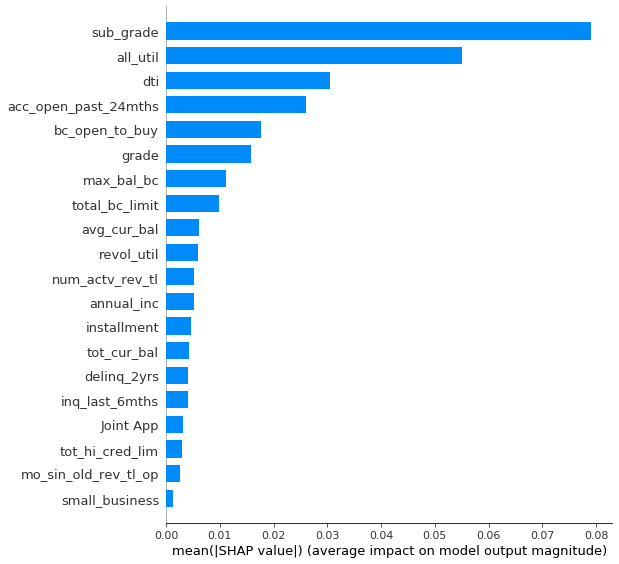

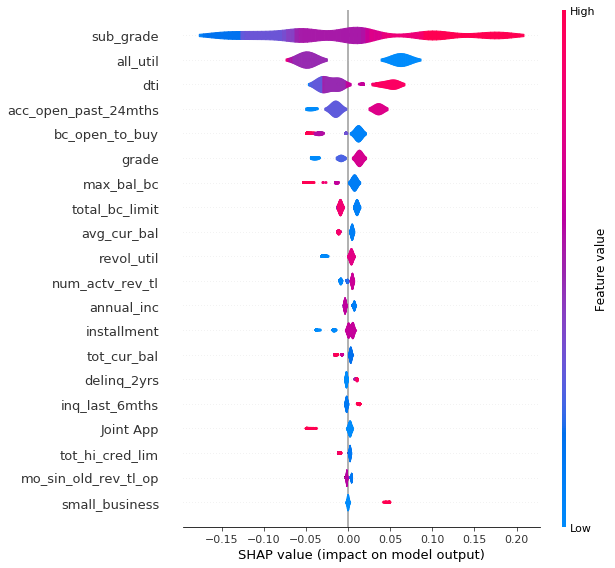

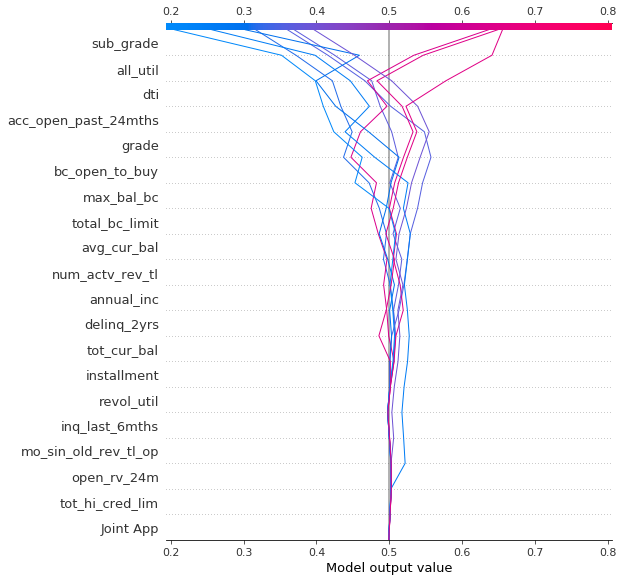

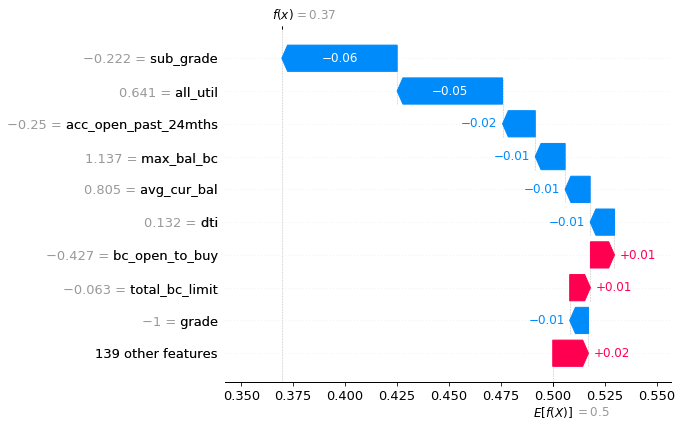

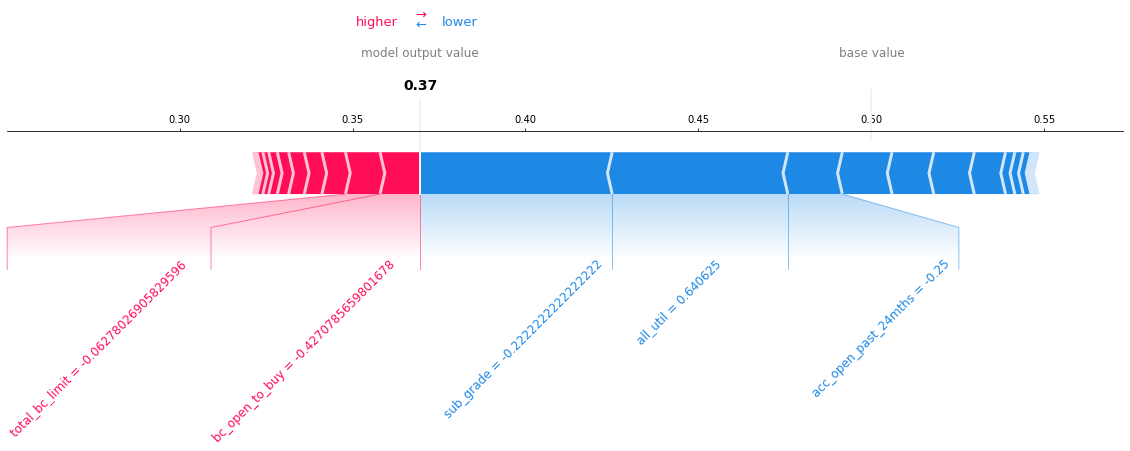

In [101]:
sampler = RandomUnderSampler(random_state=42)
cv=StratifiedKFold(n_splits=25)
model=GradientBoostingClassifier(max_depth=1)

for train_fold_index, val_fold_index in cv.split(X_s, y_s):
    # Get the training data
    X_train_fold, y_train_fold = X_s.iloc[train_fold_index], y_s.iloc[train_fold_index]
    # Get the validation data
    X_val_fold, y_val_fold = X_s.iloc[val_fold_index], y_s.iloc[val_fold_index]

# Balance only the data in the training section
X_train_fold_resamp, y_train_fold_resamp = sampler.fit_resample(X_train_fold,y_train_fold)
# Fit the model on the balanced training data
model_obj = model.fit(X_train_fold_resamp, y_train_fold_resamp)

select = range(10)
features = X_s.iloc[select]
features_display = X_s.loc[features.index]


explainer = shap.TreeExplainer(model_obj,X_train_fold_resamp, model_output='probability')
shap_values = explainer.shap_values(X_train_fold_resamp)
shap.summary_plot(shap_values,X_train_fold_resamp, plot_type='bar')
shap.summary_plot(shap_values,X_train_fold_resamp, plot_type='violin')
shap.decision_plot(explainer.expected_value, shap_values[0:10], features_display)
shap.waterfall_plot(explainer.expected_value, shap_values[1],X_train_fold_resamp.iloc[1,:])
shap.force_plot(explainer.expected_value, shap_values[1], X_train_fold_resamp.iloc[1,:], figsize=(20,5), matplotlib=True, text_rotation=45)
plt.show()

 98%|===================| 4061/4140 [00:40<00:00]        

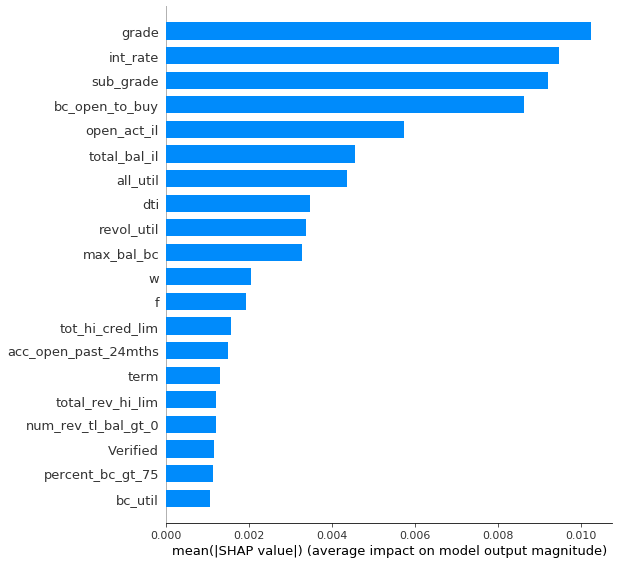

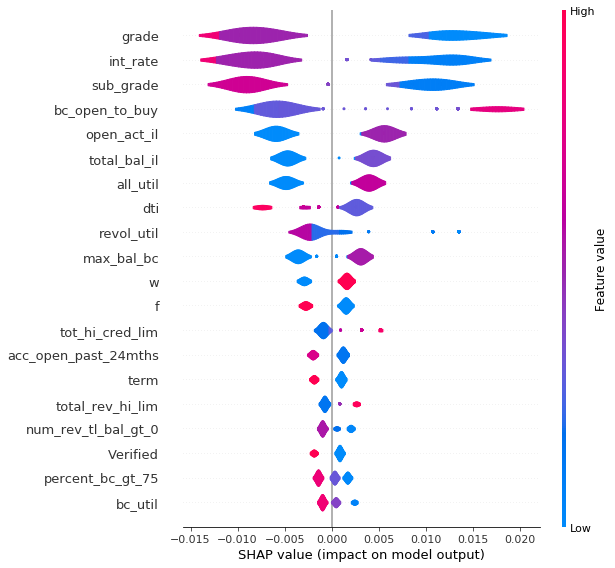

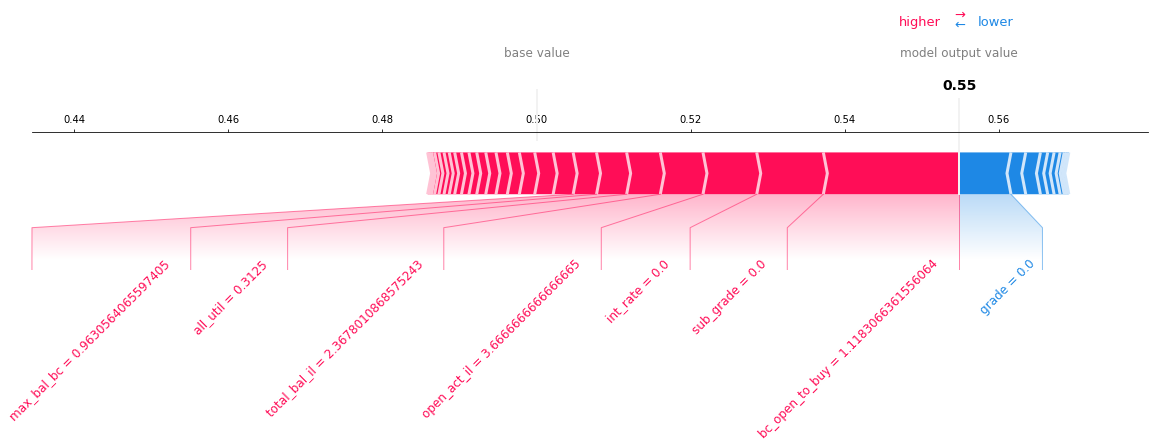

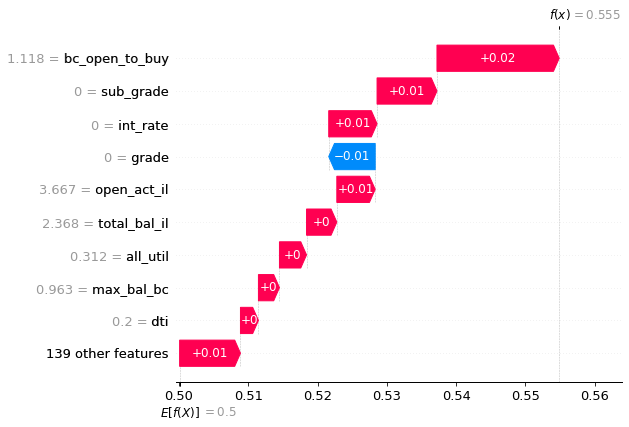

In [123]:
sampler = RandomUnderSampler(random_state=42)
cv=StratifiedKFold(n_splits=25)
model = RandomForestClassifier(max_depth=1)

for train_fold_index, val_fold_index in cv.split(X_s, y_s):
    # Get the training data
    X_train_fold, y_train_fold = X_s.iloc[train_fold_index], y_s.iloc[train_fold_index]
    # Get the validation data
    X_val_fold, y_val_fold = X_s.iloc[val_fold_index], y_s.iloc[val_fold_index]

# Balance only the data in the training section
X_train_fold_resamp, y_train_fold_resamp = sampler.fit_resample(X_train_fold,y_train_fold)
# Fit the model on the balanced training data
model_obj = model.fit(X_train_fold_resamp, y_train_fold_resamp)



explainer = shap.TreeExplainer(model_obj,X_train_fold_resamp, model_output='probability')
shap_values = explainer.shap_values(X_train_fold_resamp)
shap.summary_plot(shap_values[0],X_train_fold_resamp, plot_type='bar')
shap.summary_plot(shap_values[0],X_train_fold_resamp, plot_type='violin')
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_train_fold_resamp.iloc[0,:], figsize=(20,5), matplotlib=True, text_rotation=45)
shap.waterfall_plot(explainer.expected_value[0], shap_values[0][0],X_train_fold_resamp.iloc[0,:])
plt.show()